# This code will enable you to classify a satellite scene usinging Deep Convolutional Neural Network machine learning

## You will first need to draw polygon shapefiles for Regions of Interest (ROIs) in QGIS and export the shapefile




# Install packages (only needs to be done once)

In [ ]:
!pip install pandas
!pip install datetime
!pip install numpy
!pip install tensorflow==2.15 --force-reinstall
#!pip install keras
!pip install h5py
!pip install matplotlib
!pip install scikit-learn  
!pip install geopandas
!pip install earthpy
!pip install spectral
!pip install rasterio
!pip install rioxarray
!pip install shapely
!pip install plotly
!pip install fiona
!pip install seaborn

## Download and install GDAL (only needs to be done once)

In [ ]:
# you will only need to run this line once to determine the version of Python you have to then go download GDAL
# use this link to download the GDAL wheel file for your Python version and Windows Operating Version
# you do not need to run this Box of code if you have a Mac or Linux
# see instructions for more details
import sys
print(sys.version)

In [ ]:
# You will need to run this line once, even if you have a Windows
# Install the GDAL Wheel File
# update this file path to reflect where you are storing the GDAL file

#!pip install "C:/Users/fishr/Satellite Seagrass/Python_library/GDAL-3.4.3-cp311-cp311-win_amd64.whl"


# Import Libraries

In [1]:
import os
import sys

# Define File Path Working Dirctory and Satellite Scene Name

In [2]:
# Define all necessary input variables

# define the EPSG code as a character string
# use the following link to change the EPSG code if you will work in a different region https://spatialreference.org/ref/epsg/
# EPSG code is a standardized numerical identifier for coordinate systems and spatial reference systems 
# used to locate geographic entities on the Earth's surface. 
# The EPSG code uniquely identifies a particular coordinate reference system (CRS), 
# which includes definitions for coordinate axes, units of measurement, and transformations from one CRS to another.

epsg_code = "EPSG:32651"

# set path directory where your data are kept
path = "C:/Users/mmama/Documents/COASTAL_WATER/Indo-Pacific_Seagrass/Satellite_data/TEST"

# name of the Satellite file you will be processing
sat_file = "Masinloc_PS_20230620_Nonnormalized"

wdir = os.path.join(path, sat_file)

In [3]:
# import seagrass library file which contains many Python code functions that this code depends on
# this seagrass_lib.py file should be stored in a sub-folder called "Python_library" which is in the folder path defined above

library_dir = os.path.join(path, "Python_library")
sys.path.insert(0, library_dir)
from seagrass_lib import *

In [4]:
# increase cache size to avoid memory constraints
from osgeo import gdal
gdal.SetCacheMax(2000000000)

# Import your Shapefile from QGIS

In [8]:
# Open the shapefile that is stored in an ROIs subfolder under the Input_data subfolder, which is in your working directory
input_shp = os.path.join(wdir, "Input_data", "ROIs",  sat_file + ".shp")

shapefile = gpd.read_file(input_shp)

# Display the first few rows of the attribute table to see what the Classification ID name caterogies for your shapefile are
# these should reflect the different categories you drew in QGIS

print(shapefile.head())

# Get the column names
column_names = shapefile.columns

# Print the column names
print(column_names)

               id                                           geometry
0        Seagrass  POLYGON ((812515.144 1722986.987, 812515.144 1...
1           coral  POLYGON ((812444.292 1722572.747, 812444.292 1...
2  Submerged_sand  POLYGON ((812609.036 1722696.885, 812609.036 1...
3            Land  POLYGON ((813042.337 1722803.741, 813042.337 1...
4            Land  POLYGON ((817031.421 1719009.010, 817031.421 1...
Index(['id', 'geometry'], dtype='object')


In [10]:
# Rename the first column of the shapefile to "Classname"
shapefile = shapefile.rename(columns={shapefile.columns[0]: "Classname"})
print(shapefile.head())

# View unique values in ID column
unique_values = shapefile["Classname"].unique()

# prints all of the categories we are trying to classify
print(unique_values)

        Classname                                           geometry
0        Seagrass  POLYGON ((812515.144 1722986.987, 812515.144 1...
1           coral  POLYGON ((812444.292 1722572.747, 812444.292 1...
2  Submerged_sand  POLYGON ((812609.036 1722696.885, 812609.036 1...
3            Land  POLYGON ((813042.337 1722803.741, 813042.337 1...
4            Land  POLYGON ((817031.421 1719009.010, 817031.421 1...
['Seagrass' 'coral' 'Submerged_sand' 'Land' 'Deep_water' 'Turbid_water']


In [11]:
# Define output file for newly renamed shapefile
output_shapefile_path = os.path.join(wdir, "Input_data", "ROIs",  sat_file + ".shp")

shapefile.to_file(output_shapefile_path)

In [12]:
# Now you will split multipart polygon into singlepart polygon, but first
# define where you will save the new singlepart polygon output
output_shp = os.path.join(wdir, "Input_data", "ROIs", sat_file + "_singlepart.shp") 

# Split multipart polygon into singlepart polygon
multipart_to_singlepart(shp_fp = input_shp, out_fp = output_shp)

# Load your Satellite Scene

In [13]:
satellite_scene = gdal.Open(os.path.join(wdir, 'Input_data', 'Rrs_image', sat_file + ".TIF"))
print(os.path.join(wdir, 'Input_data', 'Rrs_image', sat_file + ".TIF"))

# see how many bands satellite scene has
if satellite_scene is not None: 
    print ("band count: " + str(satellite_scene.RasterCount))

band_num = satellite_scene.RasterCount

C:/Users/mmama/Documents/COASTAL_WATER/Indo-Pacific_Seagrass/Satellite_data/TEST\Masinloc_PS_20230620_Nonnormalized\Input_data\Rrs_image\Masinloc_PS_20230620_Nonnormalized.TIF
band count: 8


In [14]:
# Look at the pixel values of the satellite scene
satellite_scene = os.path.join(wdir, 'Input_data', 'Rrs_image', sat_file + ".TIF")
  
# Open the image file
with rio.open(satellite_scene) as src:
    # Read the raster data as a numpy array
    raster_data = src.read(1, masked=True)  # Use masked=True to handle NoData values
    
    # Get the number of rows and columns
    rows, cols = raster_data.shape
    
    # Calculate the total number of pixels
    total_pixels = rows * cols
    
    print("Total number of pixels:", total_pixels)
    
    # Get metadata including NoData value
    nodata_value = src.nodata
    metadata = src.meta
    
    # Check the data range
    data_min = np.nanmin(raster_data)  # Minimum value excluding NoData
    data_max = np.nanmax(raster_data)  # Maximum value excluding NoData
    
    # Print data range
    print("Data Range (excluding NoData):", data_min, "-", data_max)
    
    
    # Check for NoData values
    if nodata_value is not None:
        nodata_count = np.sum(raster_data.mask)  # Count NoData pixels
        print("NoData Value:", nodata_value)
        print("Number of NoData Pixels:", nodata_count)
        
total_pixels - nodata_count

Total number of pixels: 16712352
Data Range (excluding NoData): 1 - 4543
NoData Value: 0.0
Number of NoData Pixels: 444692


16267660

In [ ]:
# Open and View original satellite image
satellite_scene = os.path.join(wdir, 'Input_data', 'Rrs_image', sat_file + ".TIF")
  
# Open the image file
with rio.open(satellite_scene) as src:
    # NIR (8), red (6), and green (4), blue (2) bands for Planet
    image = src.read([6, 4, 2])

# Plot the false-color composite
plt.imshow(image.transpose(1, 2, 0))
plt.title('False-Color Composite (Red-Green-Blue)')
plt.show()

In [ ]:
# View each band of the satellite scene
satellite_scene = os.path.join(wdir, 'Input_data', 'Rrs_image', sat_file + ".TIF")

with rio.open(satellite_scene) as src:
    # Read all bands
     image = src.read(list(range(1, band_num+1)))

# Plot each band separately
fig, axes = plt.subplots(1, band_num, figsize=(20, 15))
for i in range(band_num):
    im = axes[i].imshow(image[i], cmap='gist_earth')
    axes[i].set_title(f'Band {i+1}')

# Add color bar after the last subplot
cbar = fig.colorbar(im, ax=axes[-1], orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label('Reflectance')  # Add label to the color bar

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Now Extract Category ROIs from Satellite Scene using Singlepart Polygons

In [15]:
# re-define the satellite scen you are working with
input_image = satellite_scene

# define the shapefile to be the singlepart shapefile you created above
input_shp = os.path.join(wdir, "Input_data", "ROIs", sat_file + "_singlepart.shp") 

# pick a place to save the new output tiffs, it should be in the ROI subfolder
output_ROIs = os.path.join(wdir, "Input_data", "ROIs")

In [16]:
# Display the first few rows of the attribute table to see what the ID name caterogies for your shapefile are
# these should reflect the different categories you drew in QGIS

singlepart_shapefile = gpd.read_file(input_shp)
print(singlepart_shapefile.head())

# View unique values in ID column
unique_values = singlepart_shapefile["Classname"].unique()

# prints all of the categories we are trying to classify
print(unique_values)

        Classname                                           geometry
0        Seagrass  POLYGON ((812515.144 1722986.987, 812515.144 1...
1           coral  POLYGON ((812444.292 1722572.747, 812444.292 1...
2  Submerged_sand  POLYGON ((812609.036 1722696.885, 812609.036 1...
3            Land  POLYGON ((813042.337 1722803.741, 813042.337 1...
4            Land  POLYGON ((817031.421 1719009.010, 817031.421 1...
['Seagrass' 'coral' 'Submerged_sand' 'Land' 'Deep_water' 'Turbid_water']


In [17]:
# extract the image spectra for each category ROI drawn in QGIS and save to the location you defined above
shp_to_roi(image_fp = input_image, output_dir = output_ROIs, shp_fp = input_shp, field_name = 'Classname')

# Train DCNN with Image ROIs

In [18]:
#creat a folder to store the DCNN model, saved as a .h5 file
dcnn_fp = os.path.join(wdir, "Input_data", "DCNN_model", sat_file + ".h5")

#input data for the training are the tiffs of each ROI we extracted above
input_data = os.path.join(wdir, 'Input_data', 'ROIs') 

#Run the training code
image_classes = roi_classes(shp_fp = input_shp, field_name = 'Classname')

In [19]:
train_dcnn(cnnFileName = dcnn_fp, epochs = 100 , training_data_directory = input_data, class_names = image_classes, numChannels = band_num, dimension = 3)


KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 32), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 16), dtype=tf.float32, name=None), name='dropout_1/Identity:0', description="created by layer 'dropout_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 32)          288       
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          4624      
                                                         

C:\Users\mmama\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Figure size 640x480 with 0 Axes>

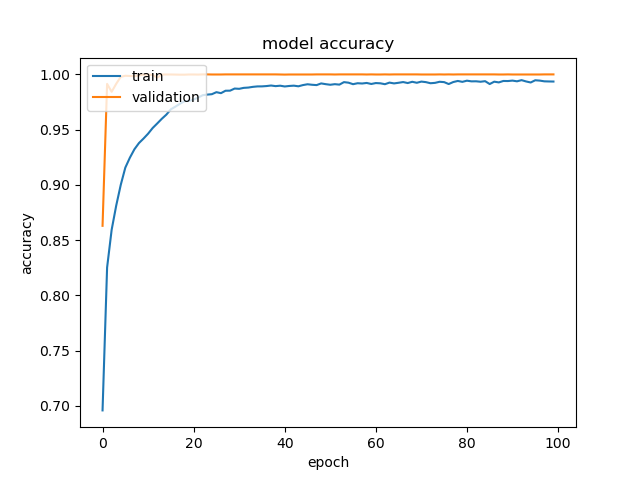

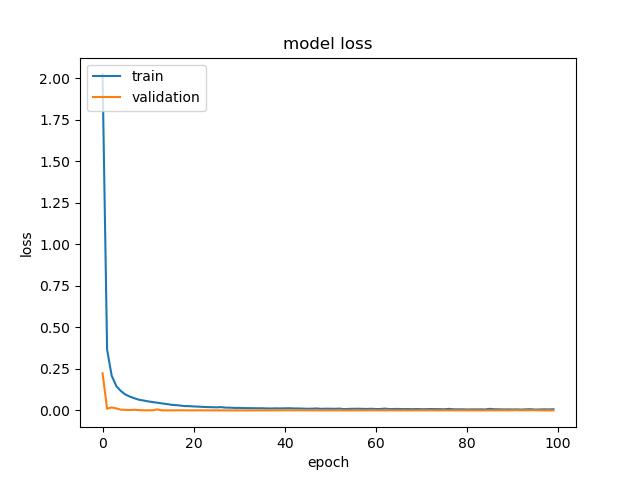

In [20]:
#View Accuracy and Loss Plots

#The accuracy plot shows how well the model is performing in terms of correctly classifying the data.
# displays the training accuracy and validation accuracy over epochs (or iterations).
# The training accuracy measures the accuracy of the model on the training dataset, 
# while the validation accuracy measures the accuracy on a separate validation dataset.
# A rising trend in both training and validation accuracy indicates that the model is learning and generalizing well.
# Fluctuations or a decrease in validation accuracy relative to training accuracy may suggest overfitting, 
# where the model performs well on the training data but fails to generalize to unseen data.


# The loss plot shows the value of the loss function (e.g., cross-entropy loss) over epochs.
# quantifies how well the model is performing. 
# A measure of the model's error or how far the predicted outputs are from the true labels.
# A decreasing trend in both training and validation loss indicates that the model is improving in its predictions 
# and learning the underlying patterns in the data.
# If the training loss decreases while the validation loss increases or remains stagnant, it may indicate overfitting.

from IPython.display import Image, display

accuracy_path = os.path.join(wdir, "Input_data", "DCNN_model", "accuracy.png")
loss_path = os.path.join(wdir, "Input_data", "DCNN_model", "loss.png")

# List of paths to your PNG files
image_paths = [accuracy_path, loss_path]

# Display each image
for i in image_paths:
    display(Image(i))


# Classify input image with trained dcnn

In [21]:
# re-define satellite scene you are working with
input_image = satellite_scene

# make a string name to save the new classified image under
classified_scene = 'classified_'+ sat_file

# define where you will save the classfied image output
output_classification = os.path.join(wdir, "Classified_image", classified_scene + ".TIF")

# define where you saved the trained DCNN .h5 model from above
dcnn_fp = os.path.join(wdir, "Input_data", "DCNN_model", sat_file + ".h5")


In [22]:
# Run the classification
dcnn_classification(image_fp = input_image, dcnn_fp = dcnn_fp, output_fp = output_classification)

82/82 [==============================] - 0s 1ms/step


# Open and View the Classified Satellite Image

In [23]:
# make a string name to save the new classified image under
classified_scene = 'classified_'+ sat_file

# open the classified satellite scene
Classification = os.path.join(wdir, "Classified_image", classified_scene + ".TIF")

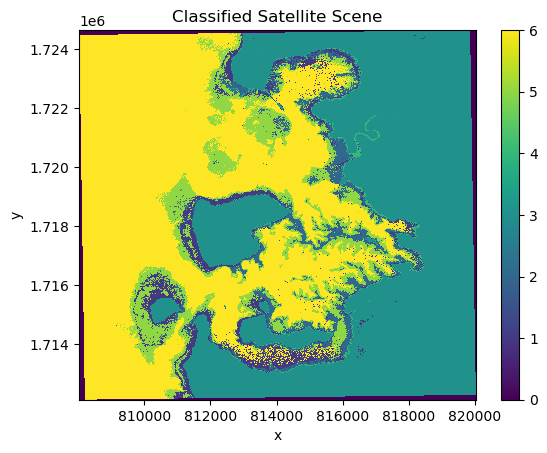

In [24]:
# Open the classified satellite scene raster dataset using rioxarray
raster = rioxarray.open_rasterio(Classification)

# Plot the raster
raster.plot()
plt.title('Classified Satellite Scene')
plt.show()


In [25]:
# Check to see how many categories of classifications there are

# Open the GeoTIFF file
with rio.open(Classification) as src:
    # Read the single band
    band = src.read(1)

    # Get unique values and their counts
    unique_values, counts = np.unique(band, return_counts=True)

    # Print unique values and their counts
    for value, count in zip(unique_values, counts):
        print(f"Value: {value}, Count: {count}")

Value: 0, Count: 461044
Value: 1, Count: 689167
Value: 2, Count: 659398
Value: 3, Count: 6553222
Value: 4, Count: 134683
Value: 5, Count: 1662730
Value: 6, Count: 6552108


Value: 0, Count: 461044
Value: 1, Count: 689167
Value: 2, Count: 659398
Value: 3, Count: 6553222
Value: 4, Count: 134683
Value: 5, Count: 1662730
Value: 6, Count: 6552108


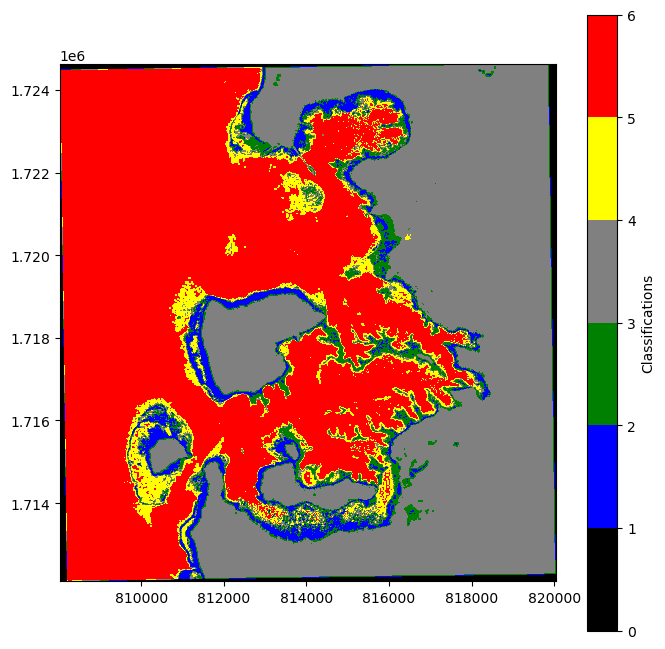

In [26]:
# Open the classified satellite GeoTIFF file and plot it in a different way
# viewing the classified satellite scene will be better in QGIS, but this is a quick way to see if the classification worked

with rio.open(Classification) as src:
    data = src.read(1)
    
    # Get unique values and their counts
    unique_values, counts = np.unique(data, return_counts=True)

    # Print unique values and their counts
    for value, count in zip(unique_values, counts):
        print(f"Value: {value}, Count: {count}")
    
    cmap = ListedColormap(['black','blue', 'green','gray','yellow','red'])  # Modify colors as needed
    bounds = [0, 1, 2, 3, 4, 5,6]  # Modify class boundaries as needed

    # Plot the data
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap=cmap, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Add color legend
    cb = plt.colorbar(ticks=bounds, boundaries=bounds)
    cb.set_label('Classifications')

    plt.show()

# Calculate the area of seagrass cover in the satellite scene

In [27]:
# Open the GeoTIFF file of the Classified Satellite Scene
# you will need to go manually inspect the classified satellite scene, either here in Jupyter Notebook, 
# or open the scene in QGIS 
# to see which number corresponds to seagrass, open water, land, submerged sand, turbid water, and NA 
# these numbers can unforutnately change each time you run the code

# from visual inspection,
# 0 is NA
# 1 is Open Water
# 2 is Seagrass
# 3 is Land
# 4 is Submerged Sand
# 5 is Turbid Water

# make a string name to save the new classified image under
classified_scene = 'classified_'+ sat_file

# open the classified satellite scene
Classification = os.path.join(wdir, "Classified_image", classified_scene + ".TIF")

with rio.open(Classification) as src:
    # Read the single band
    band = src.read(1)

    # Get unique values and their counts
    unique_values, counts = np.unique(band, return_counts=True)
    print(unique_values)

  # Initialize variables for each class count
    Unknown = 0
    Land = 0
    Turbid_water = 0
    Sand = 0
    Seagrass = 0
    Open_water = 0

    # Assign counts to respective variables
    # the order number can change
    for value, count in zip(unique_values, counts):
        if value == 0:
            Unknown = count
        if value == 1:
            Open_water = count
        elif value == 2:
            Seagrass = count
        elif value == 3:
            Land = count
        elif value == 4:
            Sand = count
        elif value == 5:
            Turbid_water = count


# Print class counts
print("Unknown count:", Unknown)
print("Land count:", Land)
print("Turbid Water count:", Turbid_water)
print("Submerged Sand count:", Sand)
print("Seagrass count:", Seagrass)
print("Open Water count:", Open_water)

[0 1 2 3 4 5 6]
Unknown count: 461044
Land count: 6553222
Turbid Water count: 1662730
Submerged Sand count: 134683
Seagrass count: 659398
Open Water count: 689167


In [28]:
square_meters_seagrass = Seagrass*9
km2_seagrass = (square_meters_seagrass / 1000000)

print("Seagrass Area in square kilometers:", km2_seagrass, "km²")


Seagrass Area in square kilometers: 5.934582 km²


# Optional: Apply Land Mask to the Classified Satellite Scene

In [31]:
# Read the land shapefile
Land_shapefile = gpd.read_file(os.path.join(path, "Land_shapefile", 'Philippines_boundary.shp'))

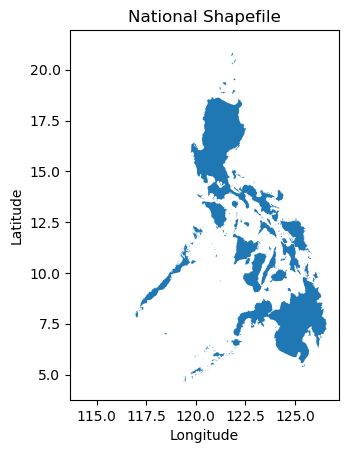

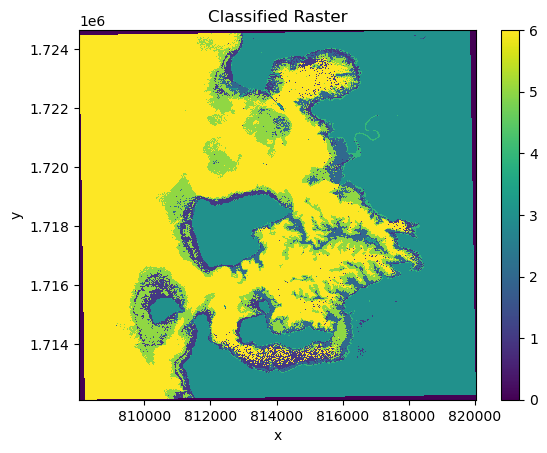

Raster CRS: EPSG:32650
Shapefile CRS: EPSG:4326


In [32]:
# Plot the shapefile to visualize it
Land_shapefile.plot()
plt.title('National Shapefile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
    
# Open the raster dataset using rioxarray
raster = rioxarray.open_rasterio(Classification)

# Plot the raster
raster.plot()
plt.title('Classified Raster')
plt.show()

# Check the CRS of both the raster and the shapefile
print("Raster CRS:", raster.rio.crs)
print("Shapefile CRS:", Land_shapefile.crs)

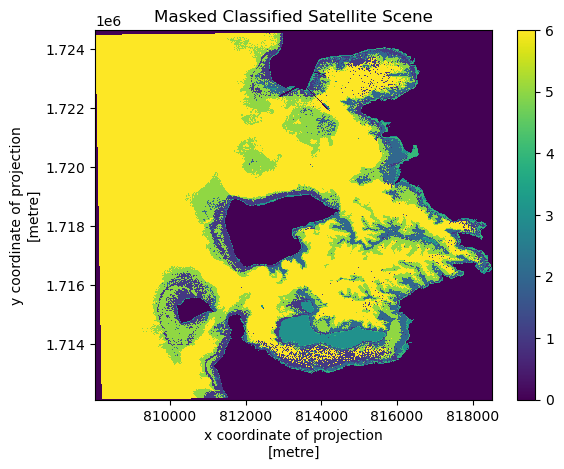

In [33]:
# Mask the Satellite Scene using the land shapefile and save it as a GeoTIFF
masked_raster = raster.rio.clip(Land_shapefile.geometry.apply(mapping), crs=Land_shapefile.crs, invert=True)

# Plot the masked raster
masked_raster.plot()
plt.title('Masked Classified Satellite Scene')
plt.show()

# Specify the output file path
output_folder = os.path.join(wdir, "Classified_image")
# make a string name to save the new classified image with land mask
masked_scene = 'masked_'+ classified_scene
output_file = os.path.join(output_folder, masked_scene + '.TIF')

# Save the masked raster as GeoTIFF
masked_raster.rio.to_raster(output_file)

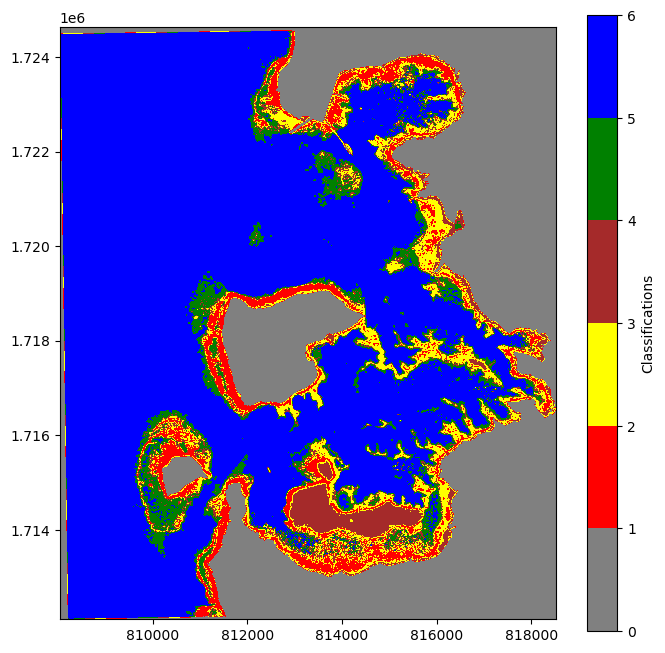

In [34]:
#Open and view the classified satellite scene with the land mask applied

Masked_scene = os.path.join(wdir, "Classified_image", masked_scene + '.TIF')

# Open the GeoTIFF file
with rio.open(Masked_scene) as src:
    data = src.read(1)
    cmap = ListedColormap(['gray', 'red', 'yellow','brown','green','blue'])  # Modify colors as needed
    bounds = [0, 1, 2, 3, 4, 5, 6 ]  # Modify class boundaries as needed

    # Plot the data
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap=cmap, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Add color legend
    cb = plt.colorbar(ticks=bounds, boundaries=bounds)
    cb.set_label('Classifications')

    plt.show()

# Statistical Assesment with USAID Shapefile

In [35]:
# Read in USAID reference data
usaid = gpd.read_file(os.path.join(path, "Field_data","USAID field data shapefile", 'Philippines_Seagrass.shp'))

In [36]:
# Print the attribute table
usaid.head()

,class_name,id,area_ha,region,province,island_grp,geometry
0,Seagrass/Seaweeds,2.0,6.957036,R4B,Palawan,None,"POLYGON Z ((839122.153 1371181.276 0.000, 8391..."
1,Seagrass/Seaweeds,2.0,2.430783,R4B,Palawan,None,"POLYGON Z ((816560.085 1368693.516 0.000, 8165..."
2,Seagrass/Seaweeds,2.0,34.670378,R4B,Palawan,None,"POLYGON Z ((821755.828 1302142.123 0.000, 8217..."
3,Seagrass/Seaweeds,2.0,7.929191,R4B,Palawan,None,"POLYGON Z ((698354.905 1121990.405 0.000, 6983..."
4,Seagrass/Seaweeds,2.0,8.533145,R4B,Palawan,None,"POLYGON Z ((855291.221 1367379.550 0.000, 8552..."


In [37]:
# Check the unique values in the column you want to use for classification
unique_values = usaid['id'].unique()
print(unique_values)

[2.]


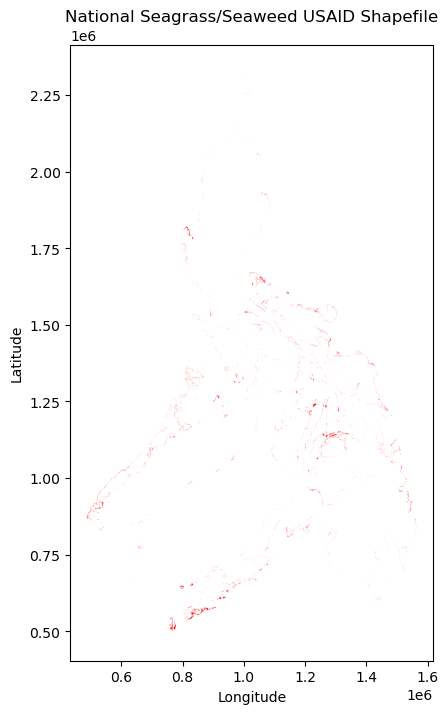

In [38]:
# Plot the shapefile to visualize it
# Create a new figure and axis with the desired figsize
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the shapefile with adjusted linewidth
usaid.plot(ax=ax, color = 'red')  # Adjust the linewidth as needed

plt.title('National Seagrass/Seaweed USAID Shapefile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [39]:
# Read in satellite classification data

# make a string name to save the new classified image under
classified_scene = 'classified_'+ sat_file

# open the classified satellite scene
Classification = os.path.join(wdir, "Classified_image", classified_scene + ".TIF")

#check EPSG code for shapefile and satellite image
with rio.open(Classification) as src:
    sat_classification = src.read(1)  # Read the first band, assuming it's the classified image
    sat_classification_meta = src.meta
    sat_classification_crs = src.crs
    
print("Satellite CRS:", sat_classification_crs)
print("Shapefile CRS:", usaid.crs)

Satellite CRS: EPSG:32650
Shapefile CRS: EPSG:32650


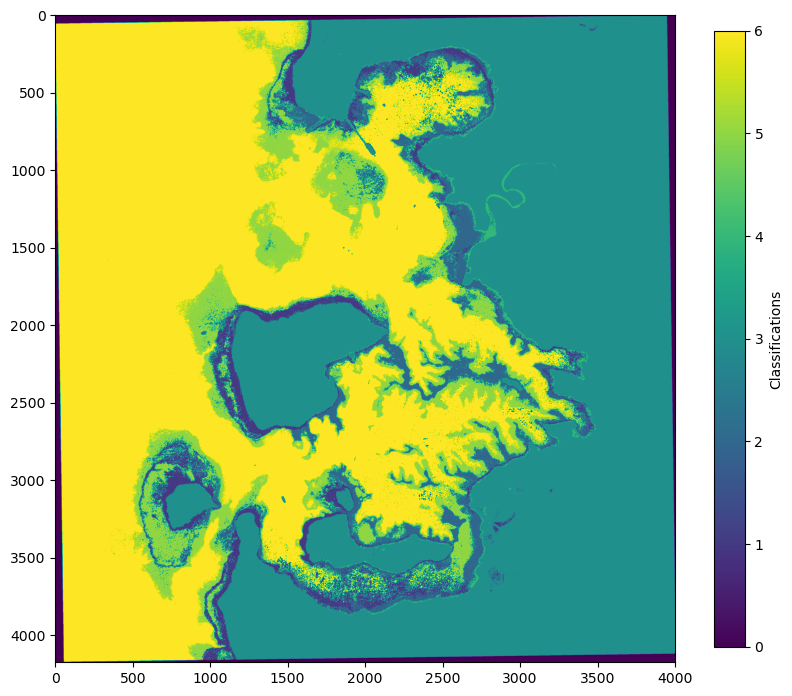

In [40]:
# Plot the satellite classification raster

# from visual inspection,
# 0 is NA
# 1 is Open Water
# 2 is Seagrass
# 3 is Land
# 4 is Submerged Sand
# 5 is Turbid Water

plt.figure(figsize=(10, 10))
plt.imshow(sat_classification, cmap='viridis')
cbar = plt.colorbar(label='Classifications', shrink=0.8)  # Adjust shrink parameter
plt.show()


          class_name   id   area_ha region  province island_grp  \
0  Seagrass/Seaweeds  2.0  0.591902     R3  ZAMBALES      LUZON   
1  Seagrass/Seaweeds  2.0  0.941642     R3  ZAMBALES      LUZON   
2  Seagrass/Seaweeds  2.0  0.098656     R3  ZAMBALES      LUZON   
3  Seagrass/Seaweeds  2.0  1.395519     R3  ZAMBALES      LUZON   
4  Seagrass/Seaweeds  2.0  1.325152     R3  ZAMBALES      LUZON   

                                            geometry  
0  POLYGON Z ((816114.237 1723121.500 0.000, 8161...  
1  POLYGON Z ((814841.178 1713291.304 0.000, 8148...  
2  POLYGON Z ((813836.193 1713082.211 0.000, 8138...  
3  POLYGON Z ((814048.571 1713111.585 0.000, 8140...  
4  POLYGON Z ((813465.694 1713129.011 0.000, 8134...  


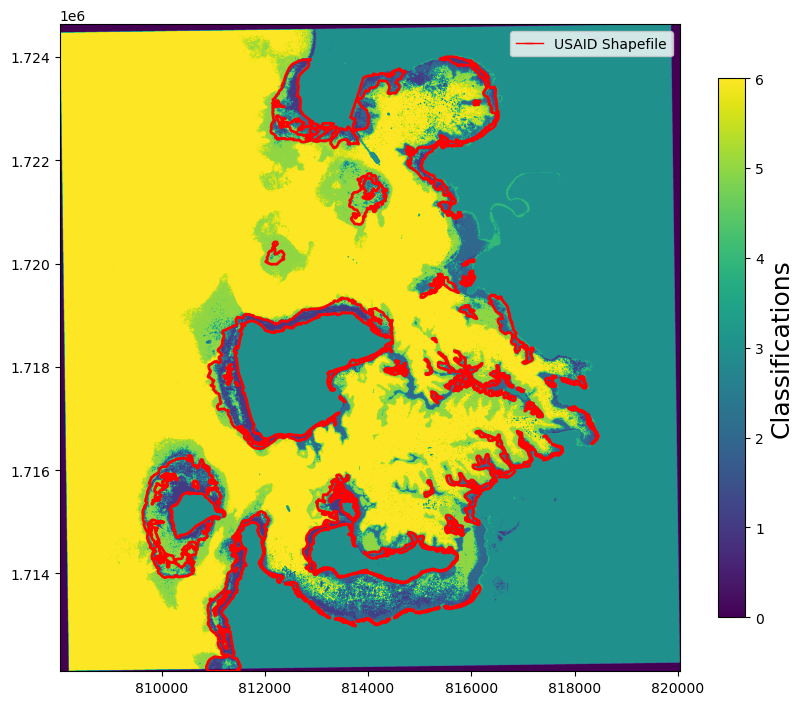

In [41]:
# Reproject the shapefile to the same coordinate system as the satellite image and 
# crop it to the extent of the satellite image
# and plot the shapefile on top of the satellite image

from shapely.geometry import shape, box
from shapely.ops import unary_union


# Open the raster image
with rio.open(Classification) as src:
    sat_classification = src.read(1)  # Read the first band, assuming it's the classified image
    # Mask the raster where the values are 0
    sat_classification_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Get the extent of the raster
    sat_classification_crs = src.crs

# Create a bounding box geometry from the raster bounds
bbox = box(*src.bounds)

# Open the shapefile
usaid_shapefile_path = os.path.join(path, "Field_data", "USAID field data shapefile", 'Philippines_Seagrass.shp')
usaid_shapefile = gpd.read_file(usaid_shapefile_path)

# Reproject the shapefile to match the CRS of the raster
usaid_shapefile = usaid_shapefile.to_crs(sat_classification_crs)

# Crop the shapefile to the extent of the bounding box
usaid_cropped = gpd.overlay(usaid_shapefile, gpd.GeoDataFrame(geometry=[bbox], crs=usaid_shapefile.crs), how='intersection')

# Display the first few rows to verify the retention of attributes
print(usaid_cropped.head())

# Plot the raster image
plt.figure(figsize=(10, 10))
plt.imshow(sat_classification, extent=sat_classification_extent, cmap='viridis')
cbar = plt.colorbar(label='Classifications', shrink=0.7)  # Adjust shrink parameter of colorbar
cbar.ax.yaxis.label.set_size(18)  # Set font size of color bar label

# Plot the cropped shapefile on top of the raster
usaid_cropped.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=2)

# Create custom legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='_', color='r', linewidth=1, label='USAID Shapefile')]
legend_labels = ['USAID Shapefile']

# Add legend
plt.legend(handles=legend_handles, labels=legend_labels)

plt.show()


In [42]:
print(usaid_cropped.columns)


Index(['class_name', 'id', 'area_ha', 'region', 'province', 'island_grp',
       'geometry'],
      dtype='object')


In [43]:
# View the usaid cropped shapefile to make sure it cropped properly and retained its attributes and ID
# Check the unique values in the 'id' column
unique_values = usaid_cropped['id'].unique()
print(unique_values)

usaid_cropped.head()


[2.]


,class_name,id,area_ha,region,province,island_grp,geometry
0,Seagrass/Seaweeds,2.0,0.591902,R3,ZAMBALES,LUZON,"POLYGON Z ((816114.237 1723121.500 0.000, 8161..."
1,Seagrass/Seaweeds,2.0,0.941642,R3,ZAMBALES,LUZON,"POLYGON Z ((814841.178 1713291.304 0.000, 8148..."
2,Seagrass/Seaweeds,2.0,0.098656,R3,ZAMBALES,LUZON,"POLYGON Z ((813836.193 1713082.211 0.000, 8138..."
3,Seagrass/Seaweeds,2.0,1.395519,R3,ZAMBALES,LUZON,"POLYGON Z ((814048.571 1713111.585 0.000, 8140..."
4,Seagrass/Seaweeds,2.0,1.325152,R3,ZAMBALES,LUZON,"POLYGON Z ((813465.694 1713129.011 0.000, 8134..."


In [45]:
# Reclassify satellite results to match the categories used in the USAID data
# You'll need to define your reclassification rules based on the categories used in the USAID data
# For simplicity, let's assume the categories are "Land", "No_data", "Submerged_sand", "Deep_water", and "Seagrass"

# from visual inspection,
# 0 is Unknown
# 1 is Seagrass
# 2 is Submerged sand
# 3 is Land
# 4 is Turbid water
# 5 is Corals
# 6 is Deep water


sat_reclass = np.copy(sat_classification) # get the classification numbers from the satellite scene

# Convert the array to a signed integer type
sat_reclass = sat_reclass.astype(np.int16)

# Set "Unknown", "Land", and "Turbid_water" to NaN
sat_reclass[(sat_reclass == 0) | (sat_reclass == 3)| (sat_reclass == 4)] = -9999  

# Set "Submerged_sand," "Corals," and "Deep_water" to 100
sat_reclass[(sat_reclass == 2) | (sat_reclass == 5) | (sat_reclass == 6)] = 100  

# Set Seagrass to 200
sat_reclass[sat_reclass == 1] = 200


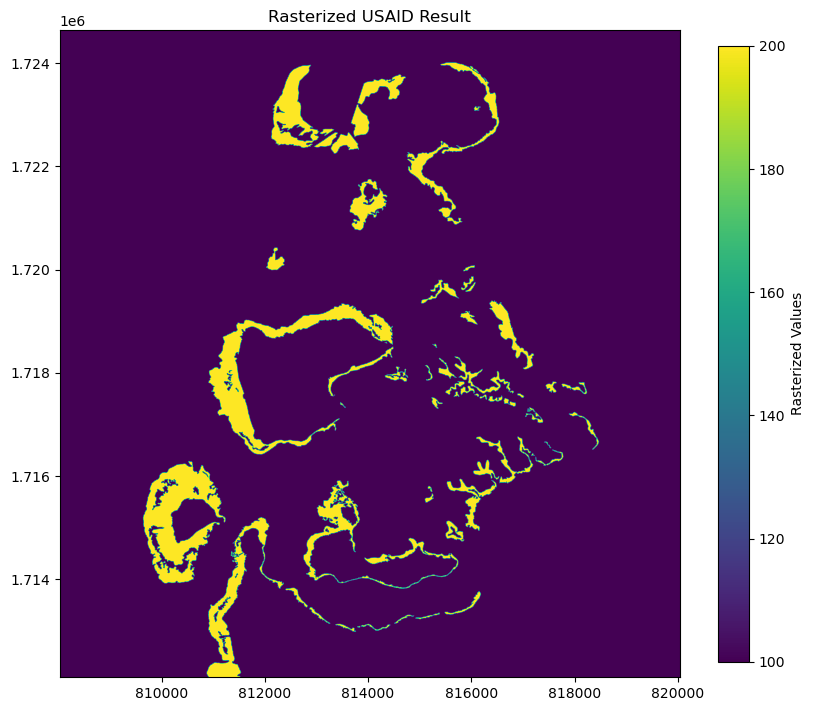

Unique raster values: [100 200]


In [46]:
# Rasterize the shapefile 
# Define raster dimensions and resolution based on the classification raster
width = sat_classification_meta['width']
height = sat_classification_meta['height']
transform = sat_classification_meta['transform']
dtype = sat_classification.dtype

# Define the rasterized ID values (2 to 200, and all others to 100)
values = [(200 if id_val == 2 else 100) for id_val in usaid_cropped['id']]

# Rasterize the GeoDataFrame into a new raster
usaid_rasterized = rasterize(
    [(geom, val) for geom, val in zip(usaid_cropped.geometry, values)],
    out_shape=(height, width),
    transform=transform,
    fill=100,
    dtype=dtype,
)

# Plot the rasterized result
plt.figure(figsize=(10, 10))
plt.imshow(usaid_rasterized, cmap='viridis', extent=sat_classification_extent)
plt.colorbar(label='Rasterized Values', shrink=0.8)
plt.title('Rasterized USAID Result')
plt.show()

# Look for unique values in usaid raster
unique_values = np.unique(usaid_rasterized)
print("Unique raster values:", unique_values)


In [47]:
# Flatten arrays for confusion matrix calculation
sat_flat = sat_reclass.flatten()
usaid_cropped_rast_flat = usaid_rasterized.flatten()

In [48]:
# Check the unique values in the USAID flatted shapefile raster -> should only be 100 and 200
np.unique(usaid_cropped_rast_flat)

array([100, 200], dtype=uint8)

In [49]:
# Check the unique values in the Satellite raster -> should only be -9999, 100, and 200
np.unique(sat_flat)

array([-9999,   100,   200], dtype=int16)

In [50]:
# Calculate confusion matrix

# Define the actual predictions and true labels
# "True data" or "Field data" should come first, so that is the usaid_cropped_rast_flat data
# "Predicted data" comes second, that is from the satellite classification sat_flat
# true_labels = usaid_cropped_rast_flat
# predicted_labels = sat_flat

# Create a confusion matrix
# Labels are specified to ensure the order in the confusion matrix
# For example, 200 represent "Seagrass" and 100 represent "Non-seagrass"

cm = confusion_matrix(usaid_cropped_rast_flat, sat_flat, labels=[200, 100])

print(cm)

[[ 398793  456842]
 [ 290374 8417394]]


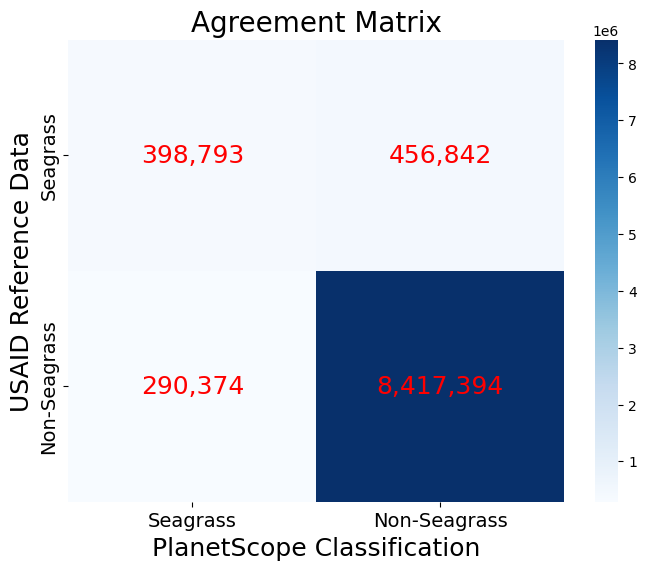

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter


# Create a confusion matrix (assuming you have defined usaid_cropped_rast_flat and sat_flat)
cm = confusion_matrix(usaid_cropped_rast_flat, sat_flat, labels=[200, 100]) 

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d', 
            xticklabels=['Seagrass', 'Non-Seagrass'], yticklabels=['Seagrass', 'Non-Seagrass'], 
            annot_kws={"fontsize": 18, "color": "red"})

# Add annotations manually
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j + 0.5, i + 0.5, '{:,}'.format(cm[i, j]), ha='center', va='center', color='red', fontsize=18)

# Adjust the font size of the tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.title('Agreement Matrix', fontsize=20 )
plt.xlabel('PlanetScope Classification', fontsize=18)
plt.ylabel('USAID Reference Data', fontsize=18)

plt.show()

In [54]:
True_positive = cm[0,0]
True_positive

398793

In [55]:
False_positive = cm[1,0]
False_positive

290374

In [56]:
False_negative = cm[0,1]
False_negative

456842

In [57]:
True_negative = cm[1,1]
True_negative

8417394

In [58]:
sensitivity = (True_positive/(True_positive + False_negative))
print("Sesitivity = ", sensitivity)

Sesitivity =  0.46607840960222524


In [59]:
specificity = (True_negative/(True_negative + False_positive))
print("Specificity = ", specificity)

Specificity =  0.9666534524116858


In [60]:
balanced_agreement = ((sensitivity+specificity)/2)
print("Balanced Agreement = ", balanced_agreement)

Balanced Agreement =  0.7163659310069554


In [61]:
print("Sesitivity = ", sensitivity)
print("Specificity = ", specificity)
print("Balanced Agreement = ", balanced_agreement)

Sesitivity =  0.46607840960222524
Specificity =  0.9666534524116858
Balanced Agreement =  0.7163659310069554


# Analyze Field Data

In [ ]:
# Analyze field data
field_data = os.path.join(path, "Field_data",'Philippines_seagrass_field_data.csv')

# Read the CSV file containing latitude and longitude data
data = pd.read_csv(field_data)  # Update with your file path
data.head()

In [ ]:
# make a string name to save the new classified image under
classified_scene = 'classified_'+ sat_file

# open the classified satellite scene
Classification = os.path.join(wdir, "Classified_image", classified_scene + ".TIF")

In [ ]:
# Plot the Field Data on top of the satellite raster

# Open the raster image
with rio.open(Classification) as src:
    sat_classification = src.read(1)  # Read the first band of the classified image
    sat_classification_extent = src.bounds  # Get the extent of the raster
    sat_classification_crs = src.crs
    print(sat_classification_crs)

    # Get the CRS of the raster
    raster_crs = sat_classification_crs
    

    # Read the CSV file containing field data coordinates
    field_data_path = os.path.join(path, "Field_data", 'Philippines_seagrass_field_data.csv')
    field_data = pd.read_csv(field_data_path)  # Update with your file path
    
    # Convert the Latitude and Longitude columns to float
    field_data['Latitude'] = field_data['Latitude'].astype(float)
    field_data['Longitude'] = field_data['Longitude'].astype(float)

    # Create a GeoDataFrame from the CSV data with Point geometries
    geometry = [Point(lon, lat) for lon, lat in zip(field_data['Longitude'], field_data['Latitude'])]
    field_gdf = gpd.GeoDataFrame(field_data, geometry=geometry, crs='EPSG:4326')  # Assuming WGS84 lat/lon coordinates

    # Reproject the GeoDataFrame to the CRS of the raster
    field_gdf = field_gdf.to_crs(raster_crs)

    # Clip the field data points to the spatial extent of the raster
    field_subset = field_gdf[field_gdf.geometry.within(box(*src.bounds))]
    

In [ ]:
# Plot the raster image 
plt.figure(figsize=(10, 10))
plt.imshow(sat_classification, extent=[sat_classification_extent.left, 
                                           sat_classification_extent.right, 
                                           sat_classification_extent.bottom, 
                                           sat_classification_extent.top], cmap='viridis')
cbar = plt.colorbar(label='Classifications', shrink=0.8)  # Adjust shrink parameter of colorbar
cbar.ax.yaxis.label.set_size(18)  # Set font size of color bar label

plt.title('Satellite Classification', fontsize=20)
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)

# Plot the clipped field data points on top of the raster image
field_subset.plot(ax=plt.gca(), color='red', markersize=5, label='Field Data', legend=True)
plt.legend()

plt.show()

In [ ]:
# view the clipped field data
field_subset.head()

In [ ]:
# Read the CRS from the vector
vector_crs = field_subset.crs
vector_crs

In [ ]:
# Check if the CRS of field sample points and satellite raster are the same
if sat_classification_crs == vector_crs:
    print("CRS match.")
else:
    print("CRS do not match.")

In [ ]:
# Look at all the unique measurement types in the field data under the column "Measurement"
# so you can decide how you want to subset the data for further anaylyses 
unique_measurements = field_subset['Measurement'].unique()
unique_measurements

In [ ]:
#Select the Measurement type that you are interested in
#here we are interested in field measrements of percent cover
percent_cover = field_subset[field_subset['Measurement'] == 'Percent cover']
percent_cover

In [ ]:
# Extract the satellite classification data 
# Create an empty list to store the extracted pixel values
extracted_pixel_values = []

# Iterate over the clipped field data points
for index, row in percent_cover.iterrows():
    # Get the coordinates of the field data point
    lon, lat = row['geometry'].x, row['geometry'].y
    
    # Convert the coordinates to pixel coordinates
    col, row = src.index(lon, lat)
    
    # Extract the pixel value from the raster
    Classification_pixel_value = sat_classification[col, row]
    
    # Append the extracted pixel value to the list
    extracted_pixel_values.append(Classification_pixel_value)

# Add the extracted pixel values to the clipped field data DataFrame
percent_cover.loc[:, 'Classification_Pixel_Values'] = extracted_pixel_values

# Display the DataFrame
percent_cover.head()

In [ ]:
# Compare the Field Data percent cover to the classification
# you will need to remember the classification numbers and what categories they correspond to

# from visual inspection,
# 0 is NA
# 1 is Open Water
# 2 is Seagrass
# 3 is Land
# 4 is Submerged Sand
# 5 is Turbid Water

# Print the total number of rows
total_rows = percent_cover.shape[0]
print("Total number of samples:", total_rows)

#Print the total number of Seagrass pixel samples
count_of_seagrass = (percent_cover['Classification_Pixel_Values'] == 2).sum()
print("Total number of Seagrass:", count_of_seagrass)

#Print the total number of Land pixel samples
count_of_land = (percent_cover['Classification_Pixel_Values'] == 3).sum()
print("Total number of Land:", count_of_land)

#Print the total number of Open Water pixel samples
count_of_open_water = (percent_cover['Classification_Pixel_Values'] == 1).sum()
print("Total number of Open Water:", count_of_open_water)

#Print the total number of Turbid Water pixel samples
count_of_turbid = (percent_cover['Classification_Pixel_Values'] == 5).sum()
print("Total number of Turbid:", count_of_turbid)

#Print the total number of Sand pixel samples
count_of_sand = (percent_cover['Classification_Pixel_Values'] == 4).sum()
print("Total number of Sand:", count_of_sand)

total_compare = total_rows-count_of_turbid
Accurate_seagrass = (count_of_seagrass/total_compare)*100
print("Classification vs Field Data Overlap =", f"{Accurate_seagrass:.2f}%")



In [ ]:
#Can compare satellite classification to field data of above ground biomass if interested
above_ground_biomass = field_subset[field_subset['Measurement'] == 'Aboveground biomass']
above_ground_biomass

In [ ]:
# Remove any "NA" rows, such as Turbid water, human-made objects, aquaculture, if those are categories in your classification

# from visual inspection,
# 0 is NA
# 1 is Open Water
# 2 is Seagrass
# 3 is Land
# 4 is Submerged Sand
# 5 is Turbid Water

# remove Turbid water which is classified as 3 in this case
seagrass_compare = percent_cover[percent_cover["Classification_Pixel_Values"]!=5]

#get number of rows and columns in new dataframe
print(seagrass_compare.shape)

#visually inspect new dataframe
seagrass_compare

In [ ]:
# from visual inspection,
# 0 is NA
# 1 is Open Water
# 2 is Seagrass
# 3 is Land
# 4 is Submerged Sand
# 5 is Turbid Water

#Convert Seagrass pixels to "200"
seagrass_compare.loc[seagrass_compare['Classification_Pixel_Values'] == 2, 'Classification_Pixel_Values'] = 200

#Convert all non-seagrass pixels to "100"
seagrass_compare.loc[seagrass_compare['Classification_Pixel_Values'] == 1, 'Classification_Pixel_Values'] = 100
seagrass_compare.loc[seagrass_compare['Classification_Pixel_Values'] == 3, 'Classification_Pixel_Values'] = 100
seagrass_compare.loc[seagrass_compare['Classification_Pixel_Values'] == 4, 'Classification_Pixel_Values'] = 100

# check unique values, all values should be either 200 for seagrass or 100 for non-seagrass
print(seagrass_compare['Classification_Pixel_Values'].unique())

#visually inspect
seagrass_compare

In [ ]:
#make a boxplot to see how the satellite classification compared to the Field Data %Cover

# Convert 'Value' column to numeric type
seagrass_compare['Value'] = pd.to_numeric(seagrass_compare['Value'], errors='coerce')

# Create boxplots
plt.figure(figsize=(10, 10))
seagrass_compare.boxplot(column='Value', by='Classification_Pixel_Values', widths=0.5, grid=False)
    
plt.title("Satellite Seagrass Classification vs Field Data", fontsize = 18)
plt.xlabel("Satellite Classification", fontsize = 16)
plt.ylabel("Field Data Seagrass % Cover", fontsize = 16)
plt.xticks([1, 2], labels=["No seagrass", "Seagrass"], rotation=0, fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

# Compare two samples - Sample 1 = non-seagrass, Sample 2 = seagrass - see if their distributions are the same
non_seagrass = seagrass_compare[seagrass_compare['Classification_Pixel_Values'] == 100]['Value']
seagrass = seagrass_compare[seagrass_compare['Classification_Pixel_Values'] == 200]['Value']

# Perform Mann-Whitney U test
# we hypothesize non-seagrass %cover distribution will be less than seagrass
statistic, p_value = mannwhitneyu(non_seagrass, seagrass, alternative='less')

# Print the results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)